In [1]:
import tensorflow as tf
from models.build_generator import build_generator
from models.build_critic import build_critic
from utils.checkpoint_manager import create_checkpoint_manager
from config.model_config import gen_learning_rate, disc_learning_rate, n_epochs, substructure_variables
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2024-10-03 15:11:58.016876: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-03 15:11:59.426775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
metrics = np.load("performance_metrics.npz")
performance_metric = metrics['performance_metric']
baseline = metrics['baseline']

losses = np.load("losses.npz")
crit_loss_avg = losses['crit_loss_avg']
gen_loss_avg = losses['gen_loss_avg']

In [3]:
substructure_variables

['w', 'q', 'm', 'tau1s', 'tau2s']

In [12]:
pd.set_option('display.float_format', '{:.3f}'.format)
baseline_df = pd.DataFrame()
performance_df = pd.DataFrame(performance_metric, columns=substructure_variables, index=pd.Index(range(1, n_epochs+1), name='Epoch'))
df = pd.concat([baseline_df, performance_df])
df['Total'] = df.sum(axis=1)
df['GenLoss'] =  list(gen_loss_avg)
df['CritLoss'] = list(crit_loss_avg)
max_threshold = 1e3
#f = df.map(lambda x: np.nan if abs(x) > max_threshold else x)

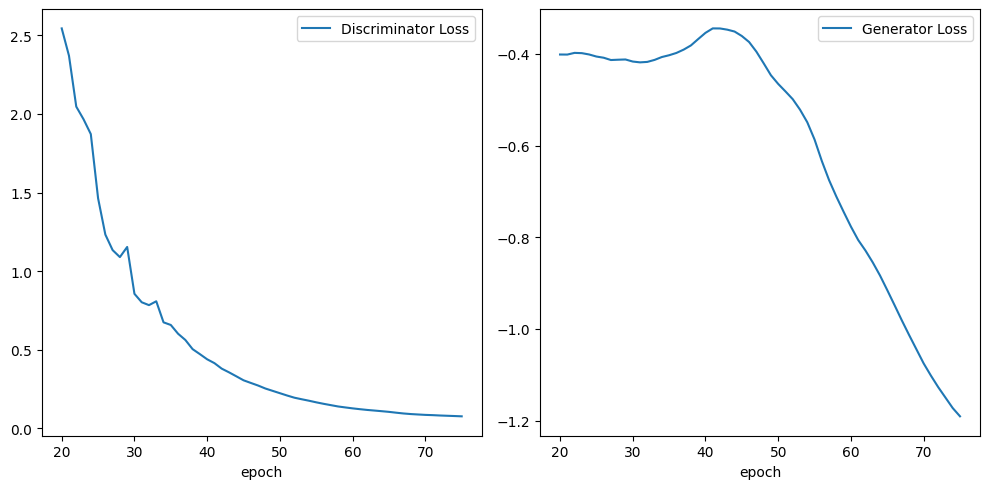

In [13]:
start_epoch = 20  # You can change this to whatever starting epoch you want

plt.figure(figsize=(10, 5))

# Discriminator Loss
plt.subplot(1, 2, 1)
plt.plot(range(start_epoch, len(crit_loss_avg) + 1), crit_loss_avg[start_epoch-1:], label='Discriminator Loss')
plt.xlabel('epoch')
plt.legend()

# Generator Loss
plt.subplot(1, 2, 2)
plt.plot(range(start_epoch, len(gen_loss_avg) + 1), gen_loss_avg[start_epoch-1:], label='Generator Loss')
plt.xlabel('epoch')
plt.legend()

plt.tight_layout()
plt.savefig("losses.pdf", bbox_inches='tight')
plt.show()

In [14]:
checkpoint_number = 75

In [15]:
substructure_variables = ['w', 'q', 'm', 'tau1s', 'tau2s']

input_shape_gen = input_shape_critic = len(substructure_variables)

model_generator = build_generator(input_shape=input_shape_gen)
model_critic = build_critic(input_shape=input_shape_critic)

2024-10-03 15:14:30.075683: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14529 MB memory:  -> device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1a:00.0, compute capability: 7.0
2024-10-03 15:14:30.076903: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 14529 MB memory:  -> device: 1, name: Tesla V100-SXM2-16GB, pci bus id: 0000:1b:00.0, compute capability: 7.0
2024-10-03 15:14:30.078278: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 14529 MB memory:  -> device: 2, name: Tesla V100-SXM2-16GB, pci bus id: 0000:3d:00.0, compute capability: 7.0
2024-10-03 15:14:30.079692: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 177 MB memory:  -> device: 3, name: Tesla V100-SXM2-16GB, pci bus id: 

In [16]:
lr_schedule = lambda initial_learning_rate : tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=1e5,
    decay_rate=0.96,
    staircase=True
)

optimizer_gen = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule(gen_learning_rate))
optimizer_critic = tf.keras.optimizers.RMSprop(learning_rate=lr_schedule(disc_learning_rate))

# Set up the checkpoint
checkpoint_dir = './model_checkpoints'
checkpoint = tf.train.Checkpoint(
    generator_optimizer=optimizer_gen,
    critic_optimizer=optimizer_critic,
    model_generator=model_generator,
    model_critic=model_critic
)

In [17]:
checkpoint_path = f'{checkpoint_dir}/ckpt-{checkpoint_number}'
checkpoint.restore(checkpoint_path).expect_partial()

In [18]:
metrics

NpzFile 'performance_metrics.npz' with keys: performance_metric, baseline

In [19]:
data = np.load("substructure_dataset/test_data.npz")
X_test_particle = data['xvals_truth']
X_test_detector = data['xvals_reco']
Y_test = data['yvals']

In [20]:
weights = model_generator.predict(X_test_particle, verbose=0).flatten()
weights[Y_test == 1] = 1

I0000 00:00:1727993677.277827 3643178 service.cc:145] XLA service 0x7f75800047b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727993677.277862 3643178 service.cc:153]   StreamExecutor device (0): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1727993677.277865 3643178 service.cc:153]   StreamExecutor device (1): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1727993677.277868 3643178 service.cc:153]   StreamExecutor device (2): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1727993677.277873 3643178 service.cc:153]   StreamExecutor device (3): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1727993677.277878 3643178 service.cc:153]   StreamExecutor device (4): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1727993677.277883 3643178 service.cc:153]   StreamExecutor device (5): Tesla V100-SXM2-16GB, Compute Capability 7.0
I0000 00:00:1727993677.277888 3643178 service.cc:153]   StreamE

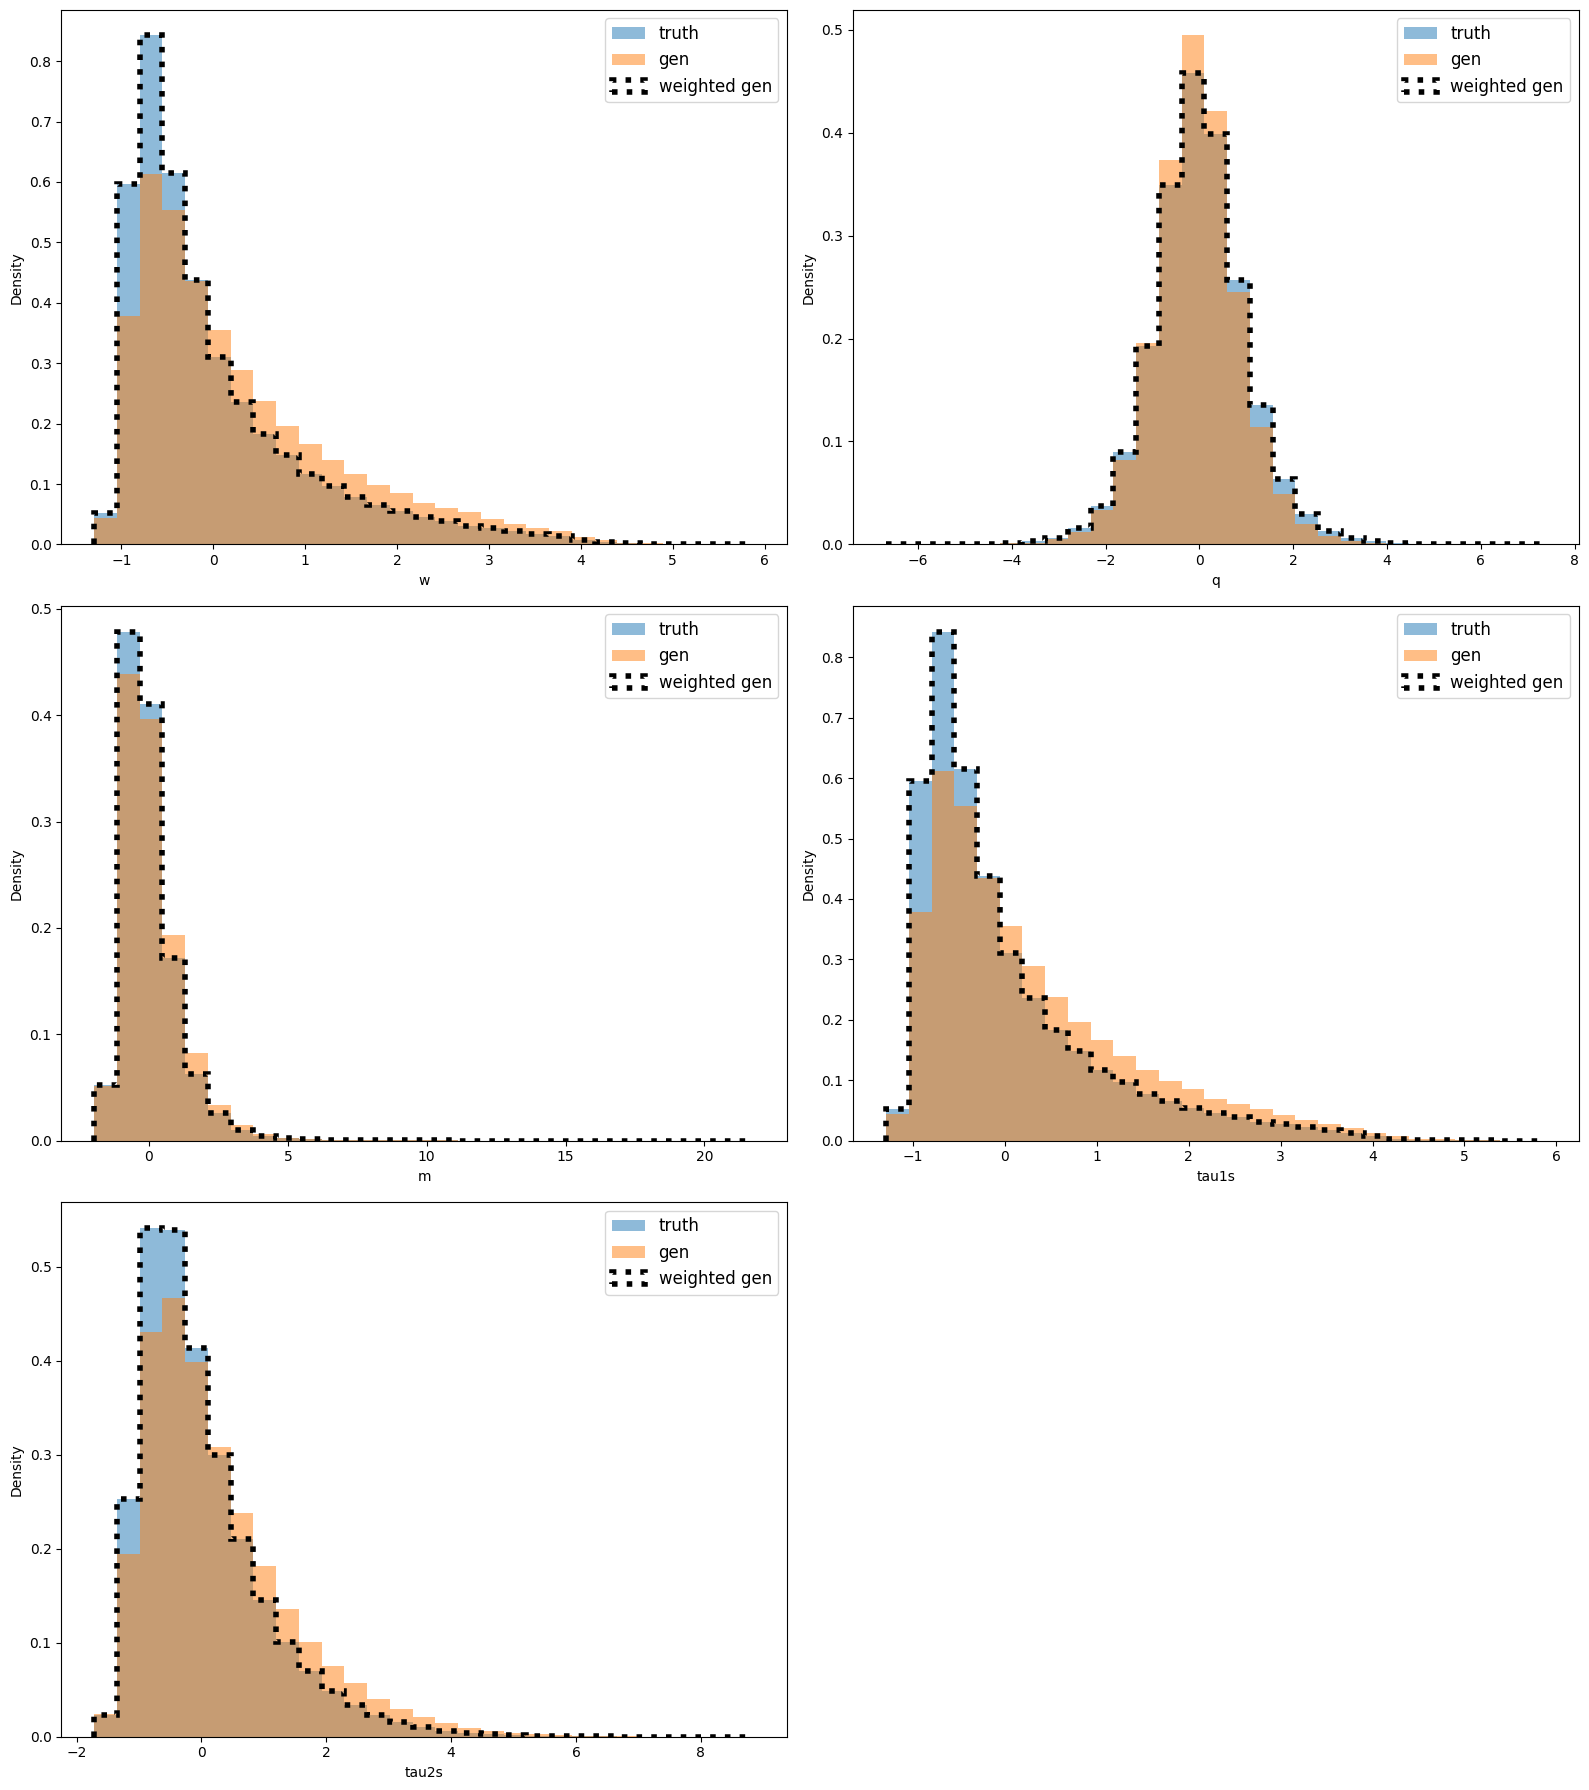

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(16, 18))
axs = axs.flatten()
nbins = 30
density = True

for i, var_name in enumerate(substructure_variables):
    X = X_test_particle[:, i]
    bins = np.linspace(X.min(), X.max(), nbins)
    
    axs[i].hist(X[Y_test == 1], bins=bins, alpha=0.5, label="truth", density=density, zorder=-1)
    axs[i].hist(X[Y_test == 0], bins=bins, alpha=0.5, label="gen", density=density, zorder=0)
    axs[i].hist(X[Y_test == 0], bins=bins, weights=weights[Y_test == 0],
                histtype="step", color="black", ls=":", lw=4, label="weighted gen", density=density, zorder=1)
    
    axs[i].legend(fontsize=12)
    axs[i].set_ylabel("Density")
    axs[i].set_xlabel(var_name)

for j in range(i + 1, len(axs)):
    axs[j].axis('off')

plt.tight_layout()
plt.savefig("plots/five_var.pdf", bbox_inches = 'tight')
plt.show()

In [ ]:
fig, axs = plt.subplots(figsize=(8, 6))
nbins = 30
density = True

for i, var_name in enumerate(['q']):
    X = X_test_particle[:, 1]
    bins = np.linspace(-3, 3, nbins)
    
    axs.hist(X[Y_test == 1], bins=bins, alpha=0.5, label="Truth", density=density, zorder=-1)
    axs.hist(X[Y_test == 0], bins=bins, alpha=0.5, label="Gen", density=density, zorder=0)
    axs.hist(X[Y_test == 0], bins=bins, weights=weights[Y_test == 0],
                histtype="step", color="black", ls="--", lw=1, label="Unf. w/o Prof.", density=density, zorder=1)
    axs.hist(X[Y_test == 1], bins=bins, weights=weights[Y_test == 1],
                histtype="step", color="red", ls="-", lw=2, label="Unf. w/ Prof.", density=density, zorder=1)
    
    axs.legend(fontsize=12)
    axs.set_ylabel("Density")
    axs.set_xlabel('x')

plt.tight_layout()
plt.savefig("plots/profile_var.pdf", bbox_inches = 'tight')
plt.show()